# STAT 4710J Final Data Challenge

A taxi company is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an rider share app account. We consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days. **The data was collected at the end of June 30, 2014.**
We would like you to use this dataset to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help the company.
The data is in the attached file data_challenge.json. See below for a detailed
description of the dataset. 

**Data description**

city: city this user signed up in

phone: primary device for this user

signup_date: date of account registration; in the form ‘YYYYMMDD’

last_trip_date: the last time this user completed a trip; in the form ‘YYYYMMDD’

avg_dist: the average distance in miles per trip taken in the first 30 days after signup

avg_rating_by_driver: the rider’s average rating over all of their trips

avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips

surge_pct: the percent of trips taken with surge multiplier > 1

avg_surge: The average surge multiplier over all of this user’s trips

trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up

ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days;

FALSE otherwise

weekday_pct: the percent of the user’s trips occurring during a weekday



Please include any code you wrote for the analysis.

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis.
2. Build a predictive model to help the company determine whether or not a user will be active
on the system. Discuss why you chose your approach, what
alternatives you considered, and any concerns you have. How valid is your model?
Include any key indicators of model performance.


**If you use Chatgpt in any of the sections, please state clearly how you reference Chatgpt, with a proper declaration, we might take you points off if we find duplicate codes produced from Chatgpt**

Grade break down: 60% on data analysis in the notebook (completeness, accuracy and interpretation) + 40% on test accuracy



In [1]:
#set up environment
import pandas as pd
import numpy as np
import json
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

#load data and visualize
with open('data_challenge.json') as f:
    data = json.load(f)
    
df = pd.DataFrame(data)
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,Winterfell,1,2014-01-27,3.5,1.67,2014-06-22,iPhone,33.3,True,16.7,2.10,4.8
1,King's Landing,1,2014-01-11,5.0,1.00,2014-06-08,iPhone,0.0,False,0.0,7.30,5.0
2,King's Landing,0,2014-01-23,3.0,1.00,2014-06-27,iPhone,0.0,True,100.0,4.00,5.0
3,King's Landing,0,2014-01-17,4.0,1.00,2014-05-31,Android,0.0,False,33.3,6.73,5.0
4,King's Landing,1,2014-01-28,5.0,1.16,2014-06-20,iPhone,26.9,True,50.0,2.48,4.8


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47500 entries, 0 to 47499
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    47500 non-null  object 
 1   trips_in_first_30_days  47500 non-null  int64  
 2   signup_date             47500 non-null  object 
 3   avg_rating_of_driver    39746 non-null  float64
 4   avg_surge               47500 non-null  float64
 5   last_trip_date          47500 non-null  object 
 6   phone                   47128 non-null  object 
 7   surge_pct               47500 non-null  float64
 8   ultimate_black_user     47500 non-null  bool   
 9   weekday_pct             47500 non-null  float64
 10  avg_dist                47500 non-null  float64
 11  avg_rating_by_driver    47311 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.4+ MB


In [3]:
df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,47500.000000,39746.000000,47500.000000,47500.000000,47500.000000,47500.000000,47311.000000
mean,2.275158,4.602186,1.074716,8.852829,60.966623,5.799024,4.778400
std,3.789220,0.617603,0.222291,19.993570,37.064133,5.677958,0.447863
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.890000,5.000000
75%,3.000000,5.000000,1.050000,8.500000,100.000000,6.950000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,129.890000,5.000000


In [4]:
#  View null values
df.isna().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      7754
avg_surge                    0
last_trip_date               0
phone                      372
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       189
dtype: int64

### 1. EDA
a. First of all, all the users will need to be labled by active or inactive, and categorical variables must be encoded. The null values must be accounted for. While the reason for the missing ratings cannot be inferred, it seems reasonable that the user/driver simply declined to input a rating. In this case, we will fill with the **mean value** so as to not affect the current distribution, which is primarily high ratings.

In [5]:
# Fill missing values in avg_rating_by_driver and avg_rating_of_driver

avg_rating_by_driver_mean = df['avg_rating_by_driver'].mean()
avg_rating_of_driver_mean = df['avg_rating_of_driver'].mean()
df['avg_rating_by_driver'].fillna(avg_rating_by_driver_mean, inplace=True)
df['avg_rating_of_driver'].fillna(avg_rating_of_driver_mean, inplace=True)

In [6]:
#  View null values
df.isna().sum()

city                        0
trips_in_first_30_days      0
signup_date                 0
avg_rating_of_driver        0
avg_surge                   0
last_trip_date              0
phone                     372
surge_pct                   0
ultimate_black_user         0
weekday_pct                 0
avg_dist                    0
avg_rating_by_driver        0
dtype: int64

In [7]:
# There aren't many missing values for "phone," so just drop them directly.
df.dropna(axis=0, how='any', inplace=True)

In [8]:
#  View null values again
df.isna().sum()

city                      0
trips_in_first_30_days    0
signup_date               0
avg_rating_of_driver      0
avg_surge                 0
last_trip_date            0
phone                     0
surge_pct                 0
ultimate_black_user       0
weekday_pct               0
avg_dist                  0
avg_rating_by_driver      0
dtype: int64

b. The target variable will be whether the user was active. Convert the signup date and last trip date to datetime objects. If the last trip is in June, then encode each user active as True, else False.

In [9]:
#set as datatime objects
# Convert the date format to datetime
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

In [10]:
# Encode target variable 'active' as true or false for last trip in june
# you can add more lines before assigning the 'active' column
# Encode the target variable 'active' as a boolean type, representing whether the user took a ride in the last June.
june_start = pd.to_datetime('2014-06-01')
june_end = pd.to_datetime('2014-07-01')
# If 'last_trip_date' greater than or equal to June 1st, 2014, and less than or equal to June 30th, 2014, then label as True; otherwise, label as False.
df['active'] = (df['last_trip_date'] >= june_start) & (df['last_trip_date'] <= june_end)
print(df[['last_trip_date', 'active']].head(10))

  last_trip_date  active
0     2014-06-22    True
1     2014-06-08    True
2     2014-06-27    True
3     2014-05-31   False
4     2014-06-20    True
5     2014-01-20   False
6     2014-05-17   False
7     2014-02-01   False
8     2014-06-01    True
9     2014-05-11   False


What is the ratio of active users to inactive users?
Calculate the percentage of active users among all users and visualize the results with a chart.

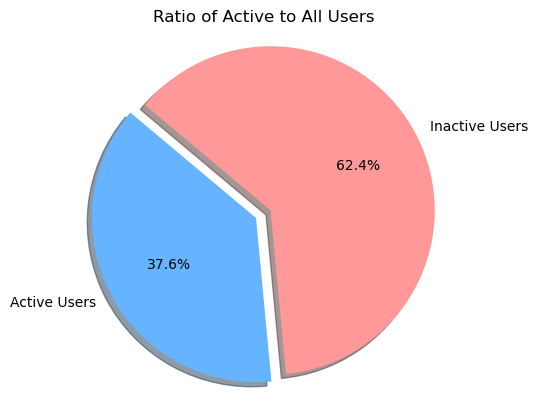

In [11]:
# Calculate ratio of active to all users
# Visualization
# Calculate the number of active users and non-active users.
active_users = df[df['active'] == True]['active'].count()
inactive_users = df[df['active'] == False]['active'].count()

# Calculate the ratio of active users to inactive users.
total_users = df.shape[0]
active_ratio = active_users / total_users
inactive_ratio = inactive_users / total_users

# Visualize the proportion of active users and inactive users.
labels = ['Active Users', 'Inactive Users']
sizes = [active_ratio, inactive_ratio]
colors = ['#66b3ff', '#ff9999']
explode = (0.1, 0)  
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  
plt.title('Ratio of Active to All Users')
plt.show()

Unsurprisingly the classes are imbalanced, but not tremendously. This should not present too much of a problem while modeling.

c. In the cell below, show a visualization that you used to select features for your model.

Include:

1. At least one plot showing something meaningful about the data that helped you during feature selection, model selection, or both.

2. Two or three sentences describing what you plotted and its implications with respect to your features.





In [12]:
# First, delete features that are not present in the test set
df.drop(['signup_date','last_trip_date'], axis=1, inplace=True)

In [13]:
# Separate discrete and continuous features
discrete_features=['city', 'trips_in_first_30_days','phone','ultimate_black_user']
continuous_features=['avg_rating_of_driver', 'avg_surge','surge_pct','weekday_pct','avg_dist','avg_rating_by_driver']

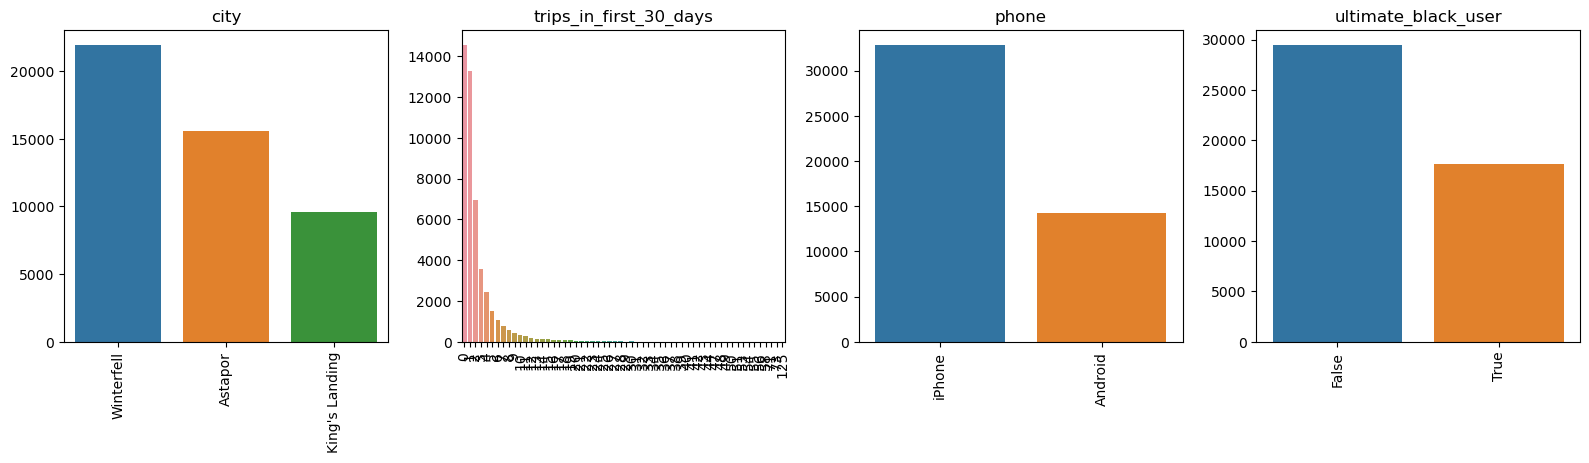

In [14]:
# Plot statistics for each value of discrete features
plt.figure(figsize=(16, 8))
i = 1
for feature in discrete_features:
    if df[feature].nunique()<100:
        plt.subplot(2, 4, i)
        i += 1
        v = df[feature].value_counts()
        fig = sns.barplot(x=v.index, y=v.values)
        for item in fig.get_xticklabels():
            item.set_rotation(90)
        plt.title(feature)
plt.tight_layout()
plt.show()

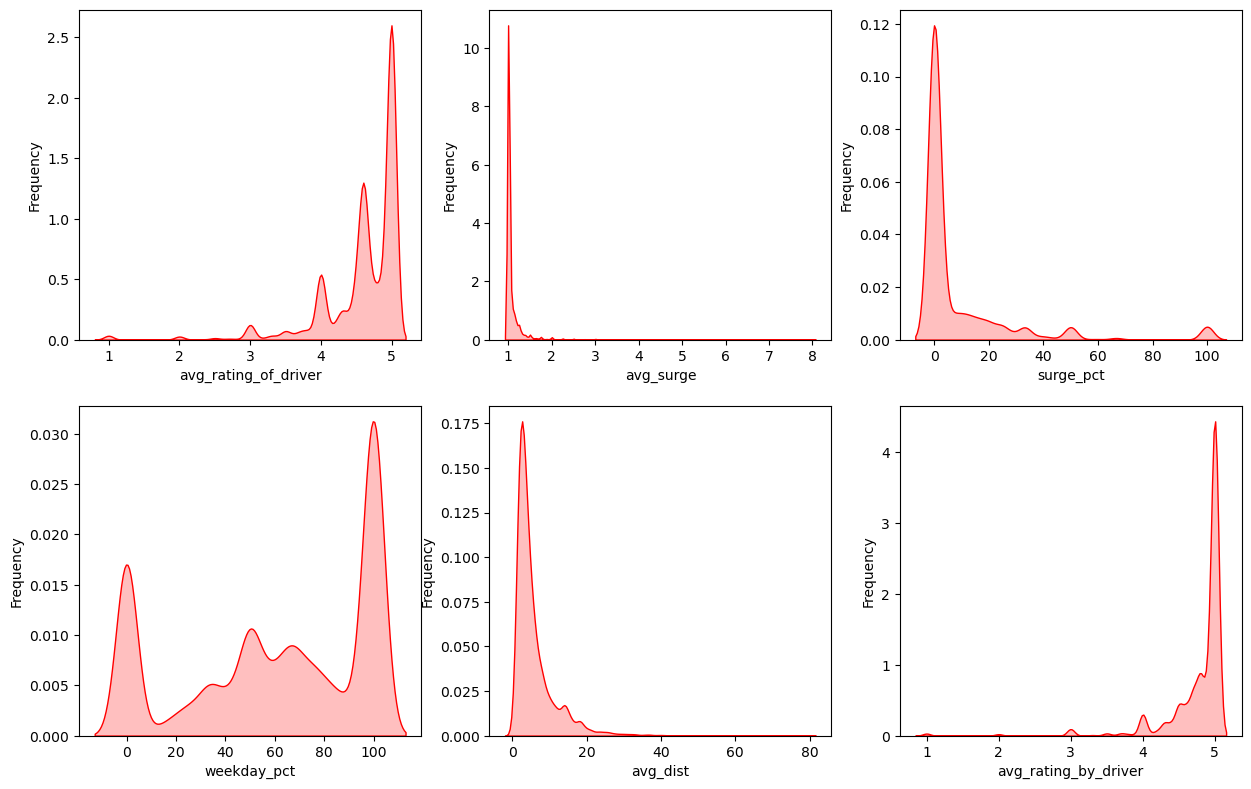

In [15]:
# Plot density estimation graph for continuous variables
dist_cols=3
dist_rows=len(continuous_features)
plt.figure(figsize=(5*dist_cols,5*dist_rows))
i=1
for feature in continuous_features:
    ax=plt.subplot(dist_rows,dist_cols,i)
    ax=sns.kdeplot(df[feature],color='Red',fill=True)
    ax.set_xlabel(feature)
    ax.set_ylabel('Frequency')
    i+=1
plt.show()

<Axes: >

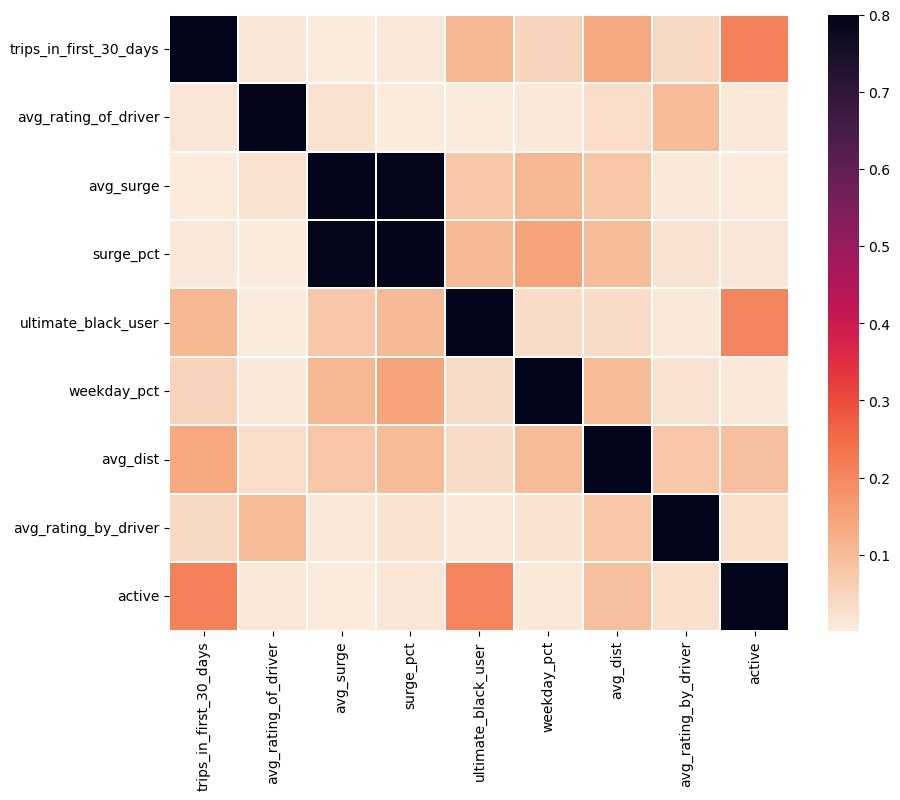

In [16]:
# Calculate the covariance and correlation of each variable
df_corr=df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(abs(df_corr),vmax=0.8,linewidths=0.05,cmap=sns.cm.rocket_r)

Based on the analysis, it can be concluded that 'trips_in_first_30_days' and 'ultimate_black_user' features have the strongest correlation with activation, while 'avg_surge' has the weakest correlation and is also densely distributed. Therefore, we will remove 'avg_dist' from the dataset.

In [17]:
df.drop(['avg_surge'], axis=1, inplace=True)

In [18]:
# Split the input and output, and perform one-hot encoding on 'city' and 'phone'
X = pd.get_dummies(df.drop(['active'], axis=1))
y = df['active']
X.columns

Index(['trips_in_first_30_days', 'avg_rating_of_driver', 'surge_pct',
       'ultimate_black_user', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver', 'city_Astapor', 'city_King's Landing',
       'city_Winterfell', 'phone_Android', 'phone_iPhone'],
      dtype='object')

## 2. Modeling

Now, please perform feature engineering to build a model that can predict whether the users are active. (To get full credit, you need to make some visualization and try out several different models using cross validation)

RandomForestClassifier Cross-Validation Accuracy: 0.7769
LogisticRegression Cross-Validation Accuracy: 0.7170
AdaBoostClassifier Cross-Validation Accuracy: 0.7813


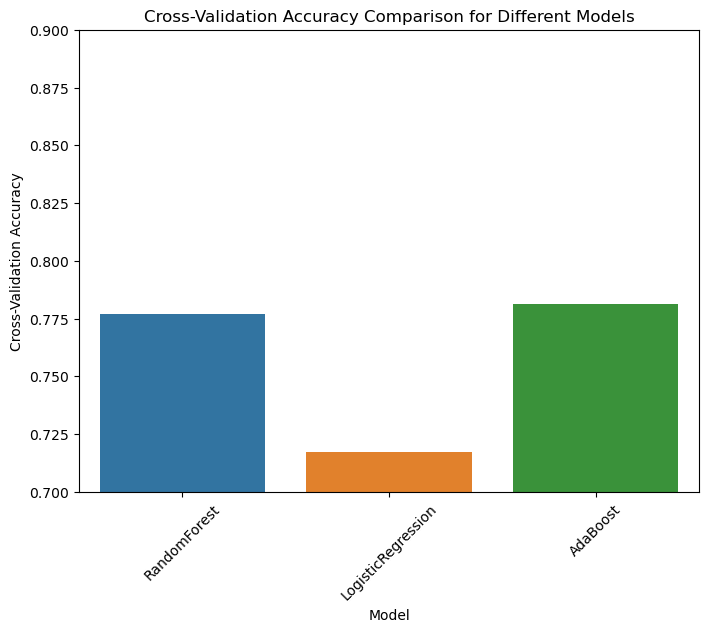

In [19]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier

# Normalize all features
scaler = MinMaxScaler(feature_range=(0,1))
X_scaled = scaler.fit_transform(X)

seed = 0
models = [RandomForestClassifier(n_estimators=50,
                                 max_depth=10,
                                 oob_score=True,
                                 class_weight="balanced", 
                                 random_state=seed),
          LogisticRegression(penalty = "l2",
                             C = 1,
                             fit_intercept=True,
                            #  class_weight="balanced",
                             solver = 'newton-cholesky',
                             random_state=seed), 
          AdaBoostClassifier(n_estimators=100,
                             learning_rate=0.85,
                             algorithm="SAMME.R",
                             random_state=seed)]
scores_list = []

for model in models:
    scores = cross_val_score(model, X_scaled, y, cv=5, scoring='accuracy')
    scores_list.append(scores)
    print(f"{model.__class__.__name__} Cross-Validation Accuracy: {scores.mean():.4f}")

plt.figure(figsize=(8, 6))
models_names = ['RandomForest', 'LogisticRegression', 'AdaBoost']
scores_means = [scores.mean() for scores in scores_list]
sns.barplot(x=models_names, y=scores_means)
plt.xlabel('Model')
plt.ylabel('Cross-Validation Accuracy')
plt.title('Cross-Validation Accuracy Comparison for Different Models')
plt.xticks(rotation=45)
plt.ylim(0.7, 0.9)
plt.show()


## 3. Model Evaluation

The bottom line here is: Was the model useful? You need to check both **numerical metrics and visual metrics**. **Please explain different performance metrics and your results.**

In [20]:
from sklearn.metrics import classification_report, confusion_matrix

# Build an AdaBoostClassifier and perform cross-validation
adaboost_model = AdaBoostClassifier(n_estimators=100,
                             learning_rate=0.85,
                             algorithm="SAMME.R",
                             random_state=seed)
adaboost_scores = cross_val_score(adaboost_model, X_scaled, y, cv=5, scoring='accuracy')

# Output cross-validation accuracy.
print(f"AdaBoost cross-validation accuracy： {adaboost_scores.mean():.4f}")

AdaBoost cross-validation accuracy： 0.7813


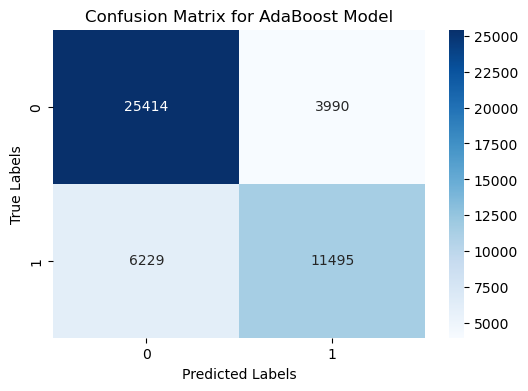

In [21]:
# Train the model using the entire dataset and make predictions.
adaboost_model.fit(X_scaled, y)
y_pred = adaboost_model.predict(X_scaled)
# Calculate the confusion matrix.
conf_matrix = confusion_matrix(y, y_pred)
# Visualize the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for AdaBoost Model')
plt.show()

Accuracy is an evaluation metric for classification models, reflecting the percentage of correct predictions out of all predictions made.

Precision is another metric, spotlighting the proportion of accurately predicted positive samples among all samples predicted as positive. It underlines the veracity of positive predictions.

Recall quantifies a classifier's competence in accurately identifying positive samples. It emphasizes the number of positive samples correctly predicted out of the total true positive samples.

Given their respective areas of focus, precision and recall are frequently employed evaluation metrics in classification problems. As they concurrently examine the precision of predictions and the capacity to correctly identify positive samples, it's important to consider both metrics for a well-rounded evaluation.

In [22]:
# Output classification report.
class_report = classification_report(y, y_pred)
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

       False       0.80      0.86      0.83     29404
        True       0.74      0.65      0.69     17724

    accuracy                           0.78     47128
   macro avg       0.77      0.76      0.76     47128
weighted avg       0.78      0.78      0.78     47128



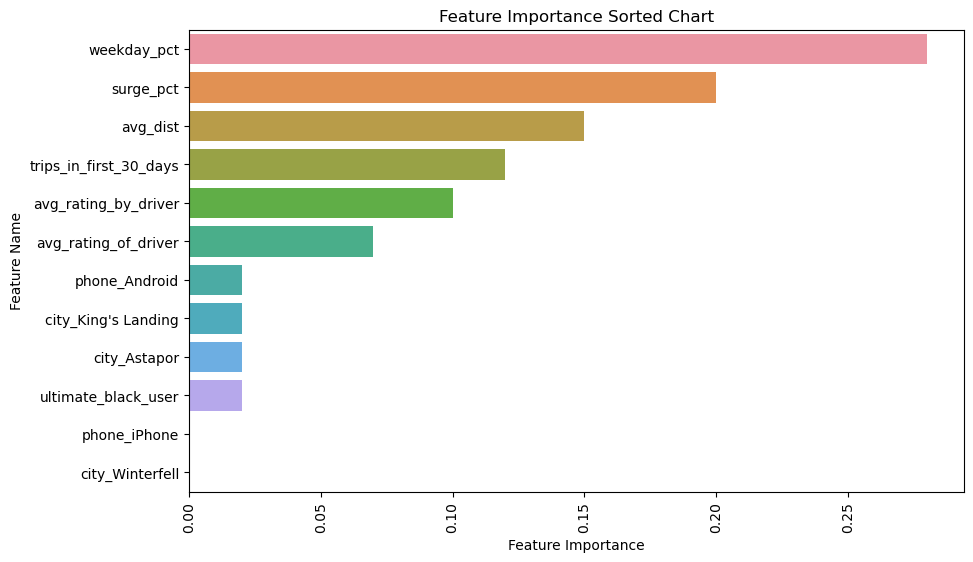

In [23]:
 # Get feature importance and sort it.
feature_importance = adaboost_model.feature_importances_
sorted_indices = np.argsort(feature_importance)[::-1]

# Visualize based on the sorted feature importance.
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance[sorted_indices], y=X.columns[sorted_indices])
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Feature Importance Sorted Chart')
plt.xticks(rotation=90)
plt.show()

"Feature importance" denotes a measurement utilized in machine learning models to gauge the influence of input features on the predictive results of the model. This metric assists in determining which features substantially impact the model's decision-making process. As indicated by the graph, weekday_pct emerges as the most significant feature, corroborating our intuitive supposition.

## 4. Final Submission




The following code will write your predictions on the test dataset to a CSV file. **You will need to submit this file to get credit for this question.**

Save your predictions in a 1-dimensional array called `test_predictions` (contains 0 and 1s). 

Remember that if you've performed transformations or featurization on the training data, you must also perform the same transformations on the test data in order to make predictions. 



### Submission on Gitea

Please push all your work (ipynb, submission.csv) to the `-final` repo on Gitea. All your work should be on the master branch. 

### Submission on Canvas

Just in case you have issues with Git, submit the same items on Canvas.




In [24]:
# Load and preprocess test data
test = pd.read_csv('data/test.csv')
# Fill missing values in avg_rating_by_driver and avg_rating_of_driver
test['avg_rating_by_driver'].fillna(test['avg_rating_by_driver'].mean(), inplace=True)
test['avg_rating_of_driver'].fillna(test['avg_rating_of_driver'].mean(), inplace=True)
test_encoded = pd.get_dummies(test)
test_encoded = test_encoded[X.columns]
test_scaled = scaler.transform(test_encoded)
# Make predictions on the test data
test_predictions = adaboost_model.predict(test_scaled)

In [25]:
submission_df = pd.DataFrame({ 
    "active": test_predictions
}, columns=['active'])
submission_df.to_csv("submission.csv", index=False)

print('Created a CSV file: submission.csv')
print('You may now upload this CSV file to Gitea for grading.')

Created a CSV file: submission.csv
You may now upload this CSV file to Gitea for grading.
